# Regression Model

In [1]:
# Import the necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor, plot_tree  # Use DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Regression metrics
import joblib


In [ ]:
# # Create a folder called 'models' to save the trained models
# if not os.path.exists('models'):
#     os.makedirs('models')

In [2]:
# Import the dataset
df = pd.read_csv('outputs/train_cleaned.csv')

# Review the shape of the dataset
print(df.shape)

(1460, 84)


In [60]:
# # Remove the outliers from the data using the IQR method
# # Calculate Q1 (25th percentile) and Q3 (75th percentile)
# Q1 = df['SalePrice'].quantile(0.25)
# Q3 = df['SalePrice'].quantile(0.75)

# # Compute the Interquartile Range (IQR)
# IQR = Q3 - Q1

# # Define the lower and upper bounds
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Filter out the outliers
# df = df[(df['SalePrice'] >= lower_bound) & (df['SalePrice'] <= upper_bound)]

## Apply One-hot Encoding to all the categorical Models

In [ ]:
# Identify categorical columns (excluding 'SalePrice')
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Separate categorical and continuous data
categorical_data = df[categorical_cols]
continuous_data = df.drop(columns=categorical_cols, errors='ignore')

# Function to encode categorical columns
def encode_columns(df, cols_to_encode):
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # Avoids errors from unseen categories
    df_encoded = df.copy()
    
    for col in cols_to_encode:
        Xd = ohe.fit_transform(df_encoded[[col]])  # One-hot encode the column
        unique_values = ohe.categories_[0]  # Get unique category names
        new_cols = [f"{col}_{val}" for val in unique_values]  # Create new column names
        
        # Create a new DataFrame for encoded columns
        df_ohe = pd.DataFrame(Xd, columns=new_cols, index=df_encoded.index)
        
        # Concatenate with the original DataFrame
        df_encoded = pd.concat([df_encoded, df_ohe], axis=1)

    # Drop original categorical columns
    df_encoded.drop(cols_to_encode, axis=1, inplace=True)
    
    return df_encoded

# Encode the categorical dataset
df_encoded = encode_columns(categorical_data, categorical_cols)

# Merge encoded categorical data with continuous data
df_final = pd.concat([continuous_data, df_encoded], axis=1)


## XG Boost

### Final Model

Mean Absolute Error (MAE): 15,711.47
Mean Squared Error (MSE): 609,529,603.35
R² Score: 0.9205


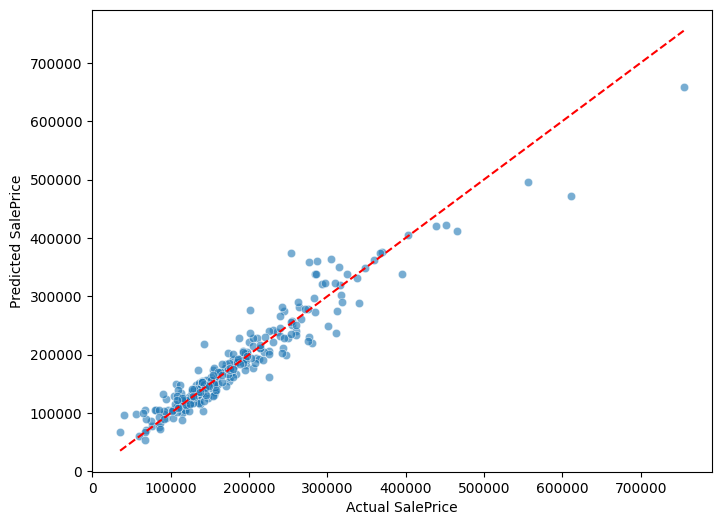

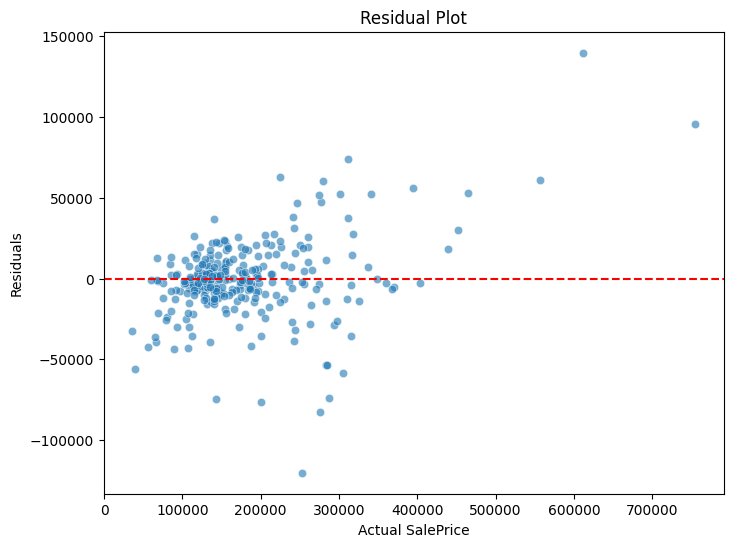

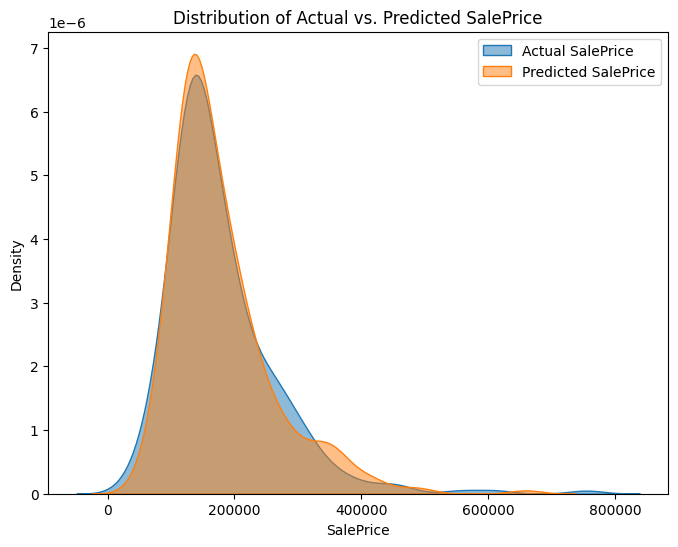

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

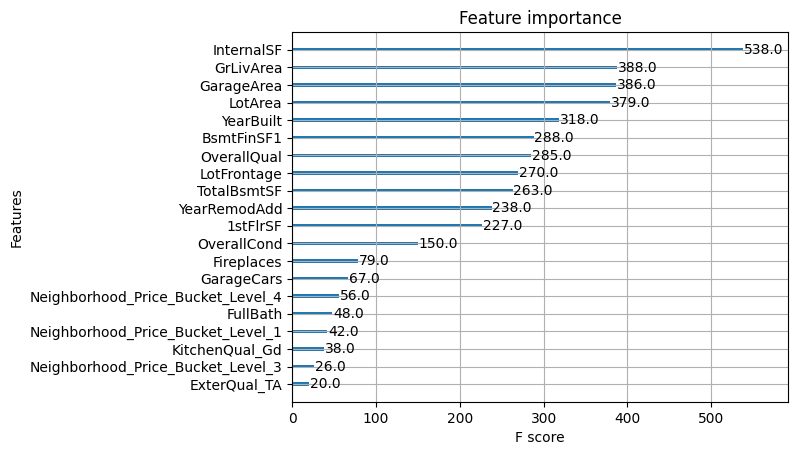

In [14]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset (Assuming df is already loaded)
# Select relevant features
df = df_final[['OverallQual', 'InternalSF', 'GrLivArea', 'GarageCars', 'GarageArea', 'FullBath', 'YearBuilt', 'TotalBsmtSF',
         'YearRemodAdd', '1stFlrSF', 'BsmtFinSF1', 'LotArea', 'LotFrontage', 'Fireplaces', 'OverallCond', 'ExterQual_TA', 
         'Neighborhood_Price_Bucket_Level_1', 'Neighborhood_Price_Bucket_Level_4', 'KitchenQual_Gd', 'Neighborhood_Price_Bucket_Level_3', 
         'SalePrice']]

# Define features and target variable
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to DMatrix format (optional, but improves XGBoost efficiency)
train_dmatrix = xgb.DMatrix(X_train, label=y_train)
test_dmatrix = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Train XGBoost model
model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train)

# Save the trained model
joblib.dump(model, 'models/xgboost_model_1.pkl')

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:,.2f}")
print(f"Mean Squared Error (MSE): {mse:,.2f}")
print(f"R² Score: {r2:.4f}")

# Actual vs. Predicted Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='dashed')  # Perfect predictions line
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.show()

# Residual Plot
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='dashed')  # Perfect fit line
plt.xlabel("Actual SalePrice")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Distribution of SalePrice Predictions
plt.figure(figsize=(8, 6))
sns.kdeplot(y_test, label="Actual SalePrice", fill=True, alpha=0.5)
sns.kdeplot(y_pred, label="Predicted SalePrice", fill=True, alpha=0.5)
plt.xlabel("SalePrice")
plt.ylabel("Density")
plt.title("Distribution of Actual vs. Predicted SalePrice")
plt.legend()
plt.show()

# Feature Importance
xgb.plot_importance(model)

### Full Dataset Feature Engineering Model

Mean Absolute Error (MAE): 18,120.54
Mean Squared Error (MSE): 814,287,210.43
R² Score: 0.8938


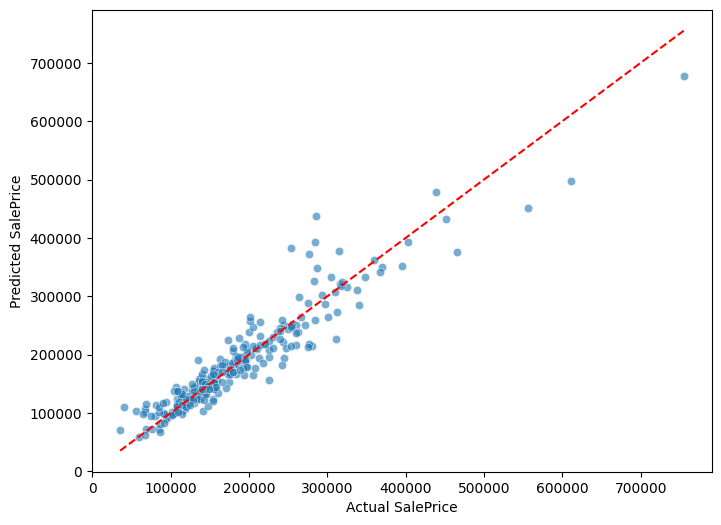

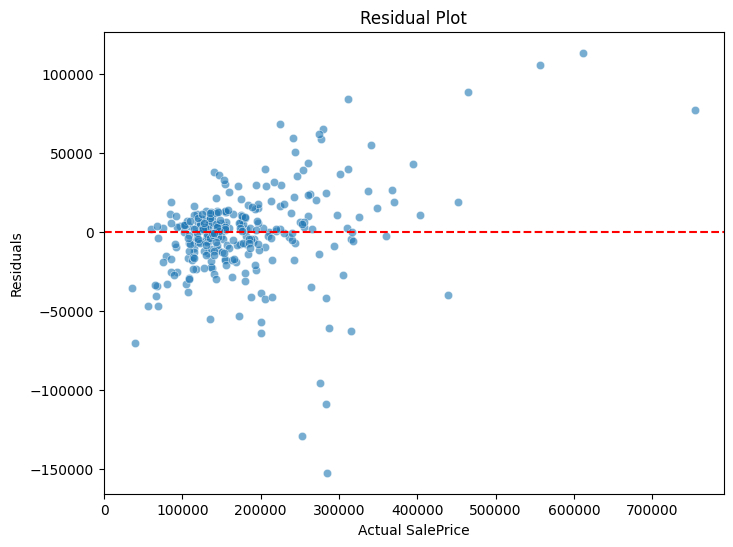

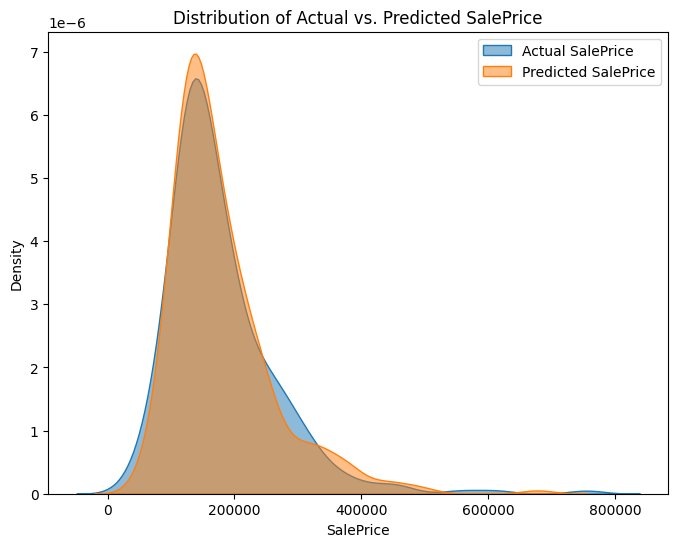

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

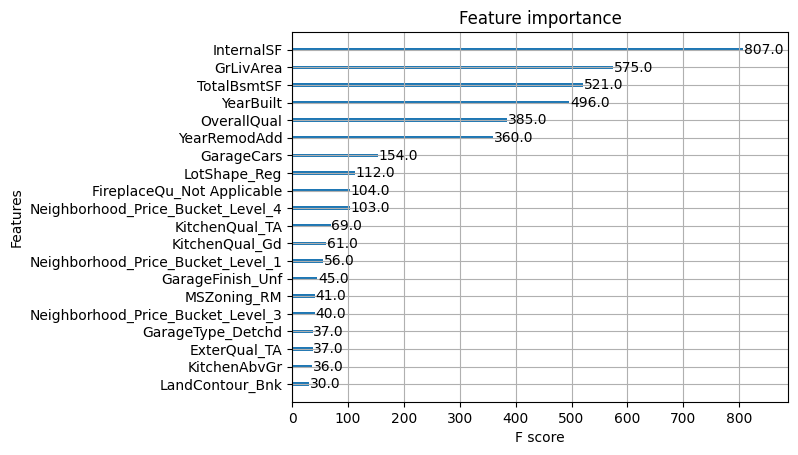

In [8]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset (Assuming df is already loaded)
# Select relevant features
df = df_final[['OverallQual', 'InternalSF', 'ExterQual_TA', 'KitchenQual_TA', 'Neighborhood_Price_Bucket_Level_1', 'GarageCars', 'Neighborhood_Price_Bucket_Level_4', 
               'GarageType_Detchd', 'KitchenAbvGr', 'FireplaceQu_Not Applicable', 'TotalBsmtSF', 'GrLivArea', 'YearBuilt', 'Neighborhood_Price_Bucket_Level_3', 
               'GarageFinish_Unf', 'LandContour_Bnk', 'LotShape_Reg', 'MSZoning_RM', 'YearRemodAdd', 'KitchenQual_Gd', 'SalePrice']]

# Define features and target variable
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to DMatrix format (optional, but improves XGBoost efficiency)
train_dmatrix = xgb.DMatrix(X_train, label=y_train)
test_dmatrix = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Train XGBoost model
model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train)

# Save the trained model
joblib.dump(model, 'models/xgboost_model_2.pkl')

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:,.2f}")
print(f"Mean Squared Error (MSE): {mse:,.2f}")
print(f"R² Score: {r2:.4f}")

# Actual vs. Predicted Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='dashed')  # Perfect predictions line
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.show()

# Residual Plot
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='dashed')  # Perfect fit line
plt.xlabel("Actual SalePrice")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Distribution of SalePrice Predictions
plt.figure(figsize=(8, 6))
sns.kdeplot(y_test, label="Actual SalePrice", fill=True, alpha=0.5)
sns.kdeplot(y_pred, label="Predicted SalePrice", fill=True, alpha=0.5)
plt.xlabel("SalePrice")
plt.ylabel("Density")
plt.title("Distribution of Actual vs. Predicted SalePrice")
plt.legend()
plt.show()

# Feature Importance
xgb.plot_importance(model)

### All features from Continuous and Categorical Data

Mean Absolute Error (MAE): 15,781.58
Mean Squared Error (MSE): 677,202,432.39
R² Score: 0.9117


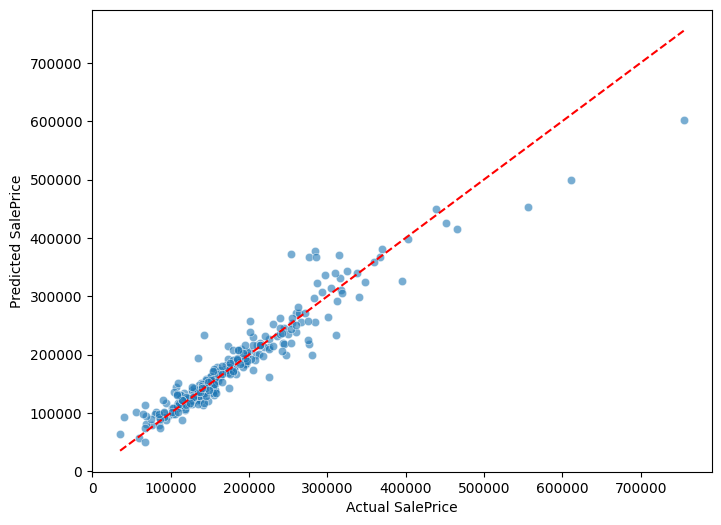

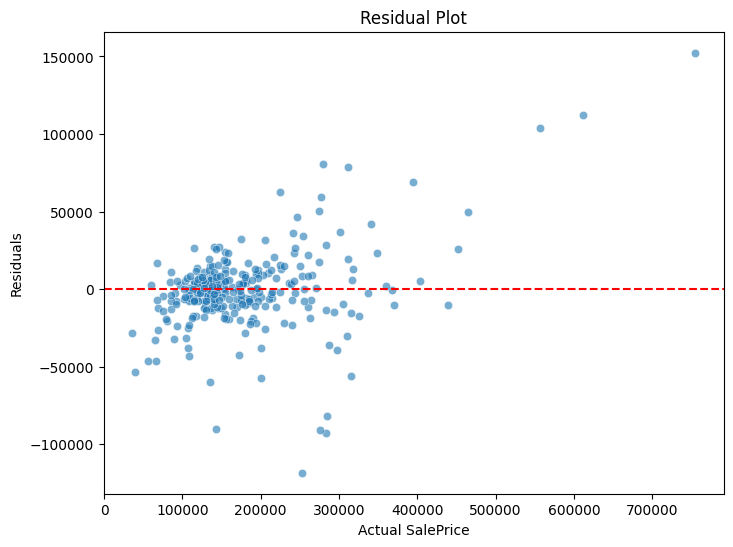

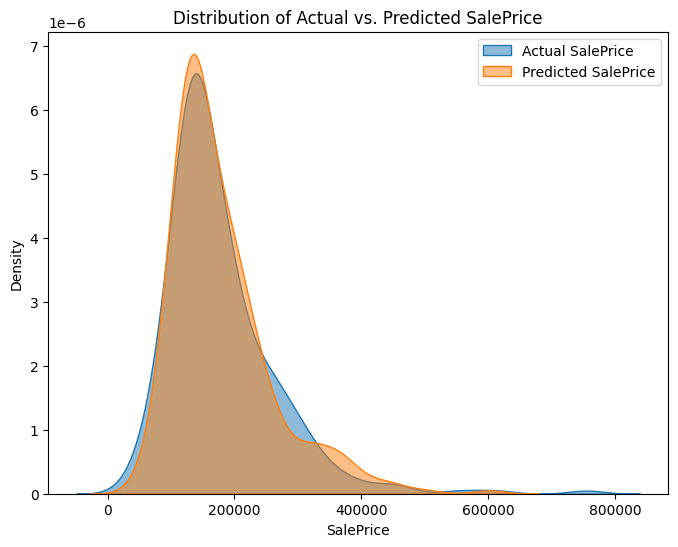

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

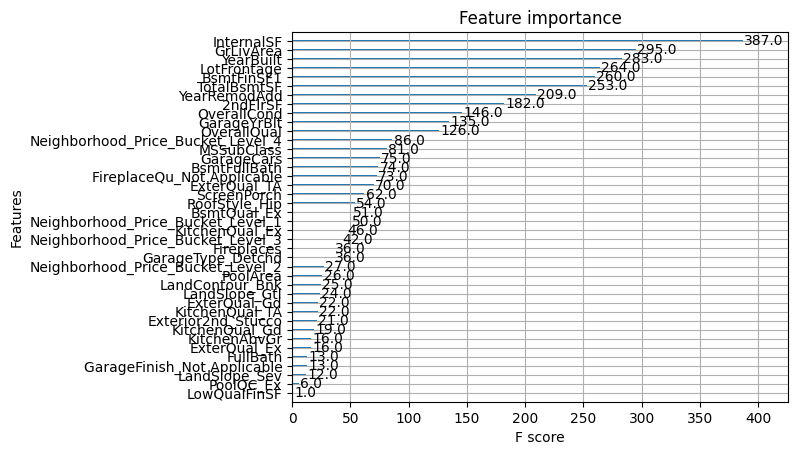

In [12]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset (Assuming df is already loaded)
# Select relevant features
df = df_final[['ExterQual_TA', 'Neighborhood_Price_Bucket_Level_4', 'BsmtQual_Ex', 'Neighborhood_Price_Bucket_Level_3', 'KitchenQual_Ex', 'LandSlope_Sev', 
 'FireplaceQu_Not Applicable', 'Neighborhood_Price_Bucket_Level_1', 'RoofStyle_Hip', 'KitchenQual_TA', 'Exterior2nd_Stucco', 'GarageType_Detchd', 
 'KitchenQual_Gd', 'PoolQC_Ex', 'LandSlope_Gtl', 'ExterQual_Gd', 'GarageFinish_Not Applicable', 'ExterQual_Ex', 'LandContour_Bnk', 
 'Neighborhood_Price_Bucket_Level_2' , 'OverallQual', 'GarageCars', 'InternalSF', 'GrLivArea', 'KitchenAbvGr', 'YearBuilt', 'YearRemodAdd', 
 '2ndFlrSF', 'PoolArea', 'Fireplaces', 'LowQualFinSF', 'OverallCond', 'LotFrontage', 'TotalBsmtSF', 'BsmtFullBath', 'ScreenPorch', 'FullBath', 
 'BsmtFinSF1', 'GarageYrBlt', 'MSSubClass', 'SalePrice']]



# Define features and target variable
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to DMatrix format (optional, but improves XGBoost efficiency)
train_dmatrix = xgb.DMatrix(X_train, label=y_train)
test_dmatrix = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Train XGBoost model
model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train)

# Save the trained model
joblib.dump(model, 'models/xgboost_model_3.pkl')

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:,.2f}")
print(f"Mean Squared Error (MSE): {mse:,.2f}")
print(f"R² Score: {r2:.4f}")

# Actual vs. Predicted Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='dashed')  # Perfect predictions line
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.show()

# Residual Plot
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='dashed')  # Perfect fit line
plt.xlabel("Actual SalePrice")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Distribution of SalePrice Predictions
plt.figure(figsize=(8, 6))
sns.kdeplot(y_test, label="Actual SalePrice", fill=True, alpha=0.5)
sns.kdeplot(y_pred, label="Predicted SalePrice", fill=True, alpha=0.5)
plt.xlabel("SalePrice")
plt.ylabel("Density")
plt.title("Distribution of Actual vs. Predicted SalePrice")
plt.legend()
plt.show()

# Feature Importance
xgb.plot_importance(model)